## Imports and Reading Datasets

In [1]:
!pip install --user uszipcode
from uszipcode import SearchEngine
import pandas as pd
import numpy as np
import random
from statsmodels.graphics.gofplots import qqplot
import matplotlib.pyplot as plt
import seaborn as sns

search = SearchEngine(simple_zipcode=True)
df = pd.read_csv('datasets/iowaliquor.csv')[['Date', 'Store Name', 'Zip Code', 'Sale (Dollars)', 'County']]
election_df = pd.read_csv('datasets/usa-2016-presidential-election-by-county.csv', sep=';')
election_df = election_df[election_df['State'] == 'Iowa']

You should consider upgrading via the 'python -m pip install --upgrade pip' command.
c:\users\arman\appdata\local\programs\python\python38\lib\site-packages\IPython\core\interactiveshell.py:3050: DtypeWarning: Columns (6,14) have mixed types. Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


## Fill Missing Zip Codes

In [2]:
unqs = df[df["Zip Code"].isna()]["Store Name"].unique() # get unique store names
cities = [store.split("/")[-1].strip().lower() for store in unqs if "/" in store] # extract city name
if "mlk" in cities:
    cities.remove("mlk")
subset = df[df["Store Name"].str.contains("/") & (df["Zip Code"].isna())] 
city_dict = {}
for city in set(cities): # get zip code from rows with cities in store name
    city_dict[city] = search.by_city_and_state(city, "iowa")[0].zipcode
city_dict["mlk"] = '50310'
df.loc[subset.index, 'Zip Code'] = subset["Store Name"].str.split("/").str[-1].str.strip().str.lower().map(city_dict) 

## Aggregate and Get Zip Code Statistics

In [3]:
df["YearMonth"] = df["Date"].str.split("/").str[2] + "-" + df["Date"].str.split("/").str[0]

df = df[df["Zip Code"].notna()]
df["Zip Code"] = df["Zip Code"].replace("712-2", 51529)
df["Zip Code"] = df["Zip Code"].astype(int)

countyDict = {}
popDict = {}

for zc in df["Zip Code"].unique():
    stats = search.by_zipcode(zc)
    if stats.state == "IA":
        countyDict[zc] = stats.county
        popDict[zc] = stats.population

In [4]:
totalZip = pd.DataFrame(df.groupby(["YearMonth", "Zip Code"])["Sale (Dollars)"].sum())
totalZip.reset_index(inplace=True)
totalZip["Population"] = totalZip["Zip Code"].map(popDict)

## County Aggregate & Add Election Data

In [5]:
totalZip["County"] = totalZip["Zip Code"].map(countyDict)
totalZip.dropna(inplace=True)
totalCounty = pd.DataFrame(totalZip.groupby(["YearMonth", "County"])["Sale (Dollars)"].sum())
totalCounty.reset_index(inplace=True)
totalCounty["Month"] = totalCounty["YearMonth"].str.split("-").str[-1]

election_df["County"] = election_df["County"].str.replace(', Iowa', "")
totalCounty = totalCounty.merge(election_df, on="County")
totalCounty["SalesPerCapita"] = totalCounty["Sale (Dollars)"] / totalCounty["Total Population"]

## Transform Variables

In [6]:
totalCounty = pd.read_csv("totalCounty.csv").drop("Unnamed: 0", axis=1)
totalCounty["LogSPC"] = np.log(totalCounty["SalesPerCapita"])
totalCounty["LogBachelors"] = np.log(totalCounty["At Least Bachelors's Degree"])
totalCounty["LogPop"] = np.log(totalCounty["Total Population"])
totalCounty["YearsPast2012"] = totalCounty["YearMonth"].str.split("-").str[0].astype(int) - 2012
totalCounty["Adult.smoking"] = totalCounty["Adult.smoking"].replace(np.nan, totalCounty["Adult.smoking"].mean())
totalCounty["Intercept"] = 1

## Linear Regression

In [7]:
cols = ["Intercept", "Month", "Median Age", "Adult.obesity", "Diabetes", "White", 
        "Less Than High School Diploma", "LogBachelors", "LogPop", "Median Earnings 2010",
        "YearsPast2012", "Adult.smoking", "Republicans 2012"]
X = totalCounty[cols]
X = np.array(pd.get_dummies(X))
y = np.array(totalCounty['LogSPC'])

b = np.linalg.inv(X.T@X)@X.T@y

np.sqrt(((np.e**y - np.e**(X@b))**2).mean())

2.7192606979118077

## QQ Plots

In [8]:
cols = ["Median Age", "Adult.obesity", "Diabetes", "White", 
        "Less Than High School Diploma", "At Least Bachelors's Degree", "Total Population", "Median Earnings 2010",
        "YearsPast2012", "Adult.smoking", "Republicans 2012"]

### No Transformations

Median Age


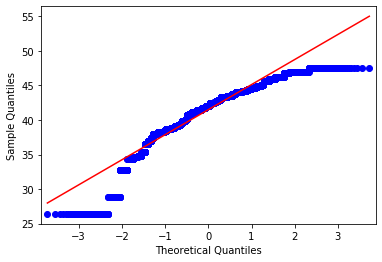

Adult.obesity


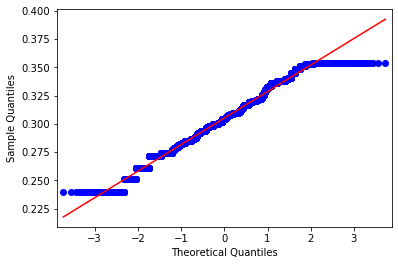

Diabetes


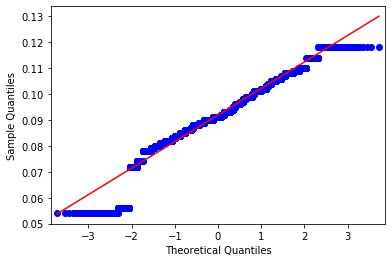

White


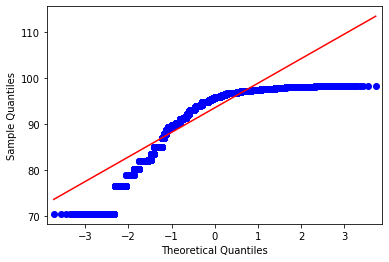

Less Than High School Diploma


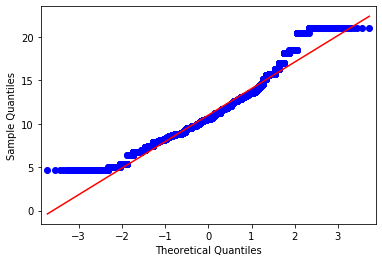

At Least Bachelors's Degree


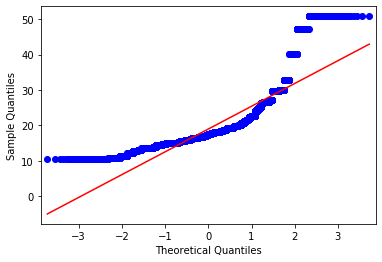

Total Population


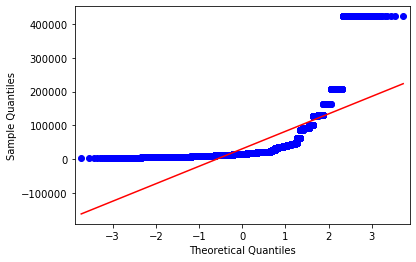

Median Earnings 2010


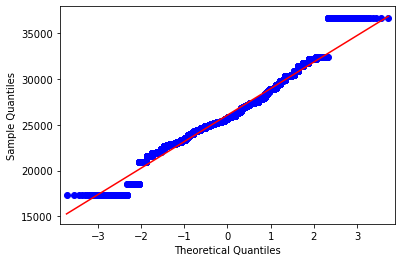

YearsPast2012


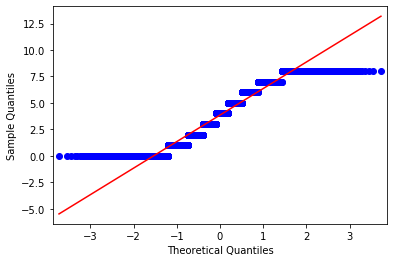

Adult.smoking


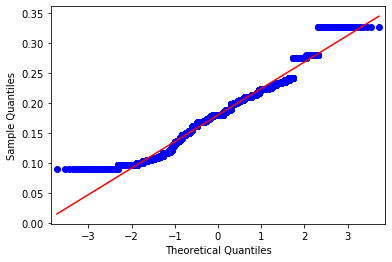

Republicans 2012


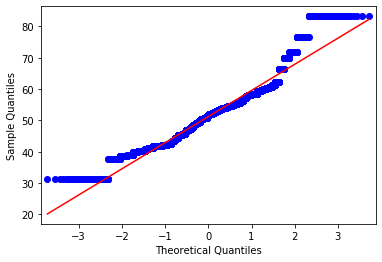

In [9]:
for col in cols:
    print(col)
    qqplot(totalCounty[col], line='s')
    plt.show()

### Log Transformation

Log(Median Age)


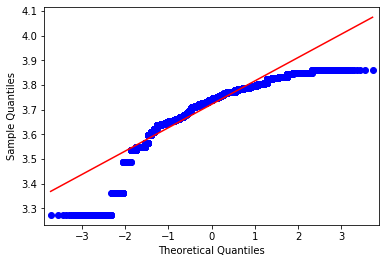

Log(Adult.obesity)


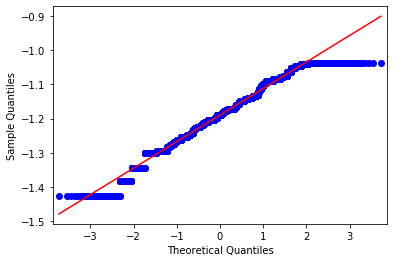

Log(Diabetes)


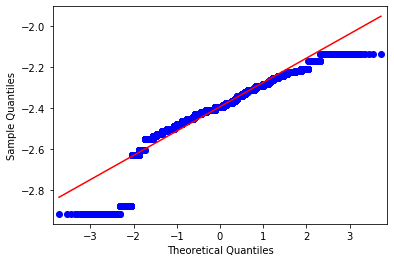

Log(White)


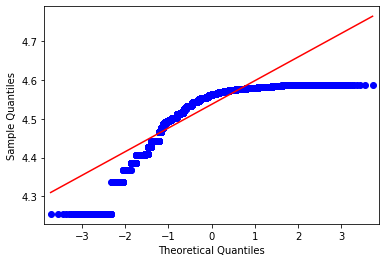

Log(Less Than High School Diploma)


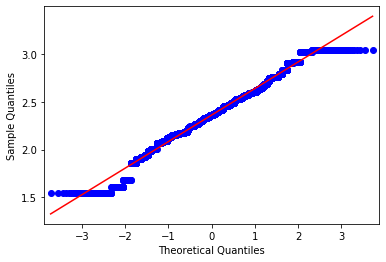

Log(At Least Bachelors's Degree)


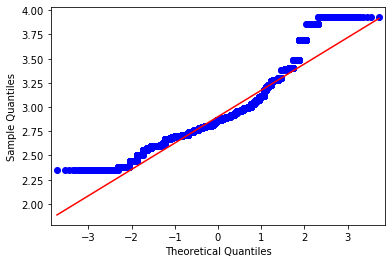

Log(Total Population)


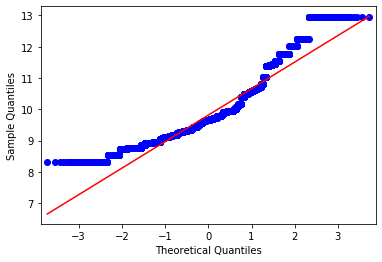

Log(Median Earnings 2010)


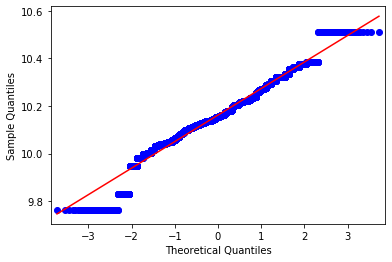

Log(YearsPast2012)


c:\users\arman\appdata\local\programs\python\python38\lib\site-packages\pandas\core\series.py:856: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\users\arman\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\_continuous_distns.py:273: RuntimeWarning: invalid value encountered in subtract
  scale = np.sqrt(((data - loc)**2).mean())
c:\users\arman\appdata\local\programs\python\python38\lib\site-packages\numpy\core\_methods.py:193: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


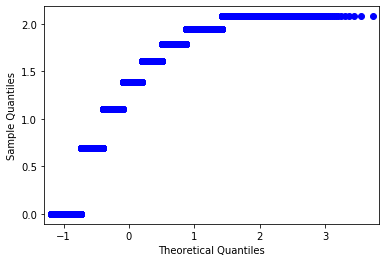

Log(Adult.smoking)


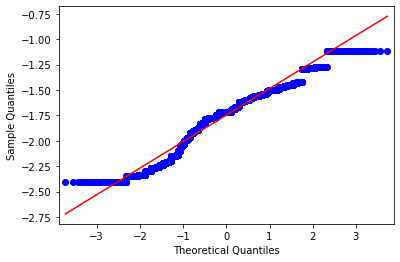

Log(Republicans 2012)


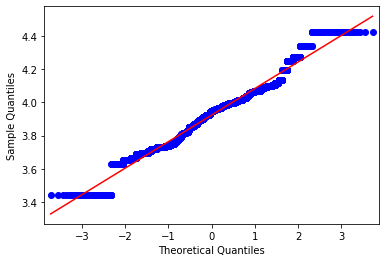

In [10]:
for col in cols:
    print('Log(' + col + ')')
    qqplot(np.log(totalCounty[col]), line='s')
    plt.show()

Looks like for Bachelor's and Total Population log is better 

But for YearsPast2012 and Adult smoking it's worse

## Plotting Linearity

### With Reverting Logs

c:\users\arman\appdata\local\programs\python\python38\lib\site-packages\seaborn\regression.py:546: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


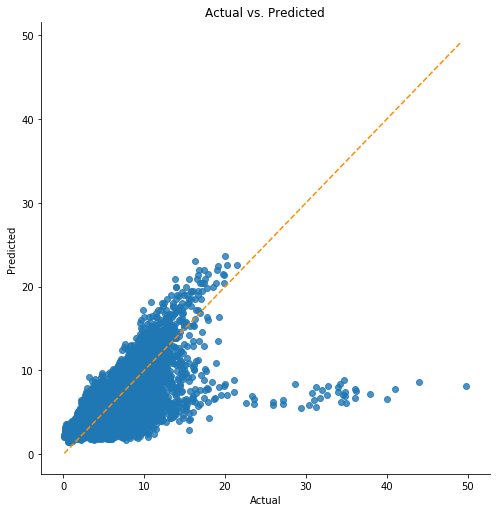

In [11]:
df_results = pd.DataFrame({'Actual': np.e ** y, 'Predicted': np.e ** (X@b)})
sns.lmplot(x='Actual', y='Predicted', data=df_results, fit_reg=False, size=7)

# Plotting the diagonal line
line_coords = np.arange(df_results.min().min(), df_results.max().max())
plt.plot(line_coords, line_coords,  # X and y points
         color='darkorange', linestyle='--')
plt.title('Actual vs. Predicted')
plt.show()

### Without Reverting Logs

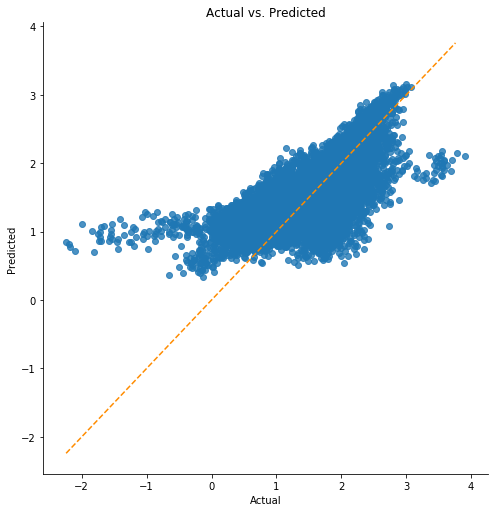

In [12]:
df_results = pd.DataFrame({'Actual': y, 'Predicted': X@b})
sns.lmplot(x='Actual', y='Predicted', data=df_results, fit_reg=False, size=7)

# Plotting the diagonal line
line_coords = np.arange(df_results.min().min(), df_results.max().max())
plt.plot(line_coords, line_coords,  # X and y points
         color='darkorange', linestyle='--')
plt.title('Actual vs. Predicted')
plt.show()